In [1]:
import pandas as pd 
import numpy as np
import sklearn

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
# pkg for interactive vis

import warnings
warnings.filterwarnings('ignore')
#把warning省略掉

%matplotlib inline

In [2]:
# Data, 資料來源
file="https://raw.githubusercontent.com/Raghavagr/Laptop_Price_Prediction/main/laptop_data.csv"
#file="Laptop_prive.csv"

df = pd.read_csv(file,index_col=0) 

In [3]:
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   object 
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   object 
 10  Price             1303 non-null   float64
dtypes: float64(2), object(9)
memory usage: 122.2+ KB


In [7]:
def fetch_processor(x):
  cpu_name = " ".join(x.split()[0:3])
  if cpu_name == 'Intel Core i7' or cpu_name == 'Intel Core i5' or cpu_name == 'Intel Core i3':
    return cpu_name
  elif cpu_name.split()[1] == 'Xeon':
    return 'Intel Xeon'
  elif cpu_name.split()[0] == 'Intel':
    return 'Other Intel Processor'
  elif cpu_name.split()[0] == 'AMD':
    return cpu_name    
  else:
    return 'Others Processor'

def EDA_CPU(df_,f_='Cpu'):
    # has one digit or none before GHz, GHz 之前有一個或沒有小數點
    pattern='([.\d]+GHz)'
    df_['CPU_vel']=(df_[f_].str.extract(pattern,expand=True))
    # keep the info before GHz, 保留 GHz 之前的資料
    df_['CPU_vel']=df_['CPU_vel'].apply(lambda x: str(x)[:-3]).astype(float)
    return df_

def EDA_GPU(df_,f_='Gpu'):
    pattern=' '
    df_['GPU']=df_[f_].str.split(pat=pattern,expand=True)[0]
    return df_

def EDA_Memory(df_,f_='Memory'):
    # split storage(s)
    # remove GB unit
    # convert TB to 1000
    # remove .0
    df1=df_.copy()
    df1[f_] = df1[f_].astype(str).replace('.0', '', regex=True)
    df1[f_] = df1[f_].str.replace('GB', '')
    df1[f_] = df1[f_].str.replace('TB', '000')
    
    # determine whether therr are two units of stoages or not
    pattern="+"
    devices = (df1[f_].str.split(pat=pattern,expand=True))
    
    # the first device
    pat1=" "
    dev0 = (devices[0].str.split(pat=pat1,expand=True))
    
    # size of storage
    pattern_1='(\d+)'
    s1=list(devices[0].str.extract(pattern_1,expand=True)[0])
    s2=list(devices[1].str.extract(pattern_1,expand=True)[0])
    # type of storage
    pattern_2='([A-Za-z+]+)'
    t1=list(devices[0].str.extract(pattern_2,expand=True)[0])
    t2=list(devices[1].str.extract(pattern_2,expand=True)[0])
    # Create features of storages
    df1['first_size']=s1
    df1['first_type']=t1
    df1['second_size']=s2
    df1['second_type']=t2
    df1['first_size'].fillna(0,inplace=True)
    df1['second_size'].fillna(0,inplace=True)
    df1['second_type'].fillna(0,inplace=True)
    df1['first_size']=df1['first_size'].astype(int)
    df1['second_size']=df1['second_size'].astype(int)
    
    # convert 0 to None id noe seconf storage, 如果沒有第二個硬碟，改為 None
    df1.loc[df1['second_type'] == 0, 'second_type'] ='None'
    
    return df1

# X-Y resolution, X, Y 解析度
def findXresolution(s):
  return s.split()[-1].split("x")[0]
def findYresolution(s):
  return s.split()[-1].split("x")[1]

# Get which OP sys, 作業系統資料
def cat_os(inp):
    if inp == 'Windows 10' or inp == 'Windows 7' or inp == 'Windows 10 S':
        return 'Windows'
    elif inp == 'macOS' or inp == 'Mac OS X':
        return 'Mac'
    else:
        return 'Others/No OS/Linux'


def EDA_basic(df_):
    
    ## remove gb and kg from Ram and weight and convert the cols to numeric, 除掉去除單位，留下數目字
    df_['Ram'] = df_['Ram'].str.replace("GB", "")
    df_['Weight'] = df_['Weight'].str.replace("kg", "")
    df_['Ram'] = df_['Ram'].astype('int32')
    df_['Weight'] = df_['Weight'].astype('float32')

    # Transform unit of price and make it in hundreds, 轉換價值單位，並最小為 00 計價  
    df_['Price'] = ((0.39*df_['Price']//100)*100).astype('int')
    
    # CGU EDA 
    df_['Cpu_brand'] = df_['Cpu'].apply(lambda x: fetch_processor(x))
    df_=EDA_CPU(df_)
    
    # GPU EDA
    df_=EDA_GPU(df_)
    
    # Storage EDA
    df_=EDA_Memory(df_,f_='Memory')
    
    # whether is Touchscreen or not, 是否為觸控面板
    df_['Touchscreen'] = df_['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)
    
    # whether  IPS is, 是否為硬版 
    df_['Ips'] = df_['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)
    
    #finding the x_res and y_res from screen resolution
    df_['X_res'] = df_['ScreenResolution'].apply(lambda x: findXresolution(x))
    df_['Y_res'] = df_['ScreenResolution'].apply(lambda y: findYresolution(y))
    #convert to numeric
    df_['X_res'] = df_['X_res'].astype('int')
    df_['Y_res'] = df_['Y_res'].astype('int')
    # Pixel per inches(PPI), having a strong correlatsolution, ion, PPI 解析度
    df_['ppi'] = (((df_['X_res']**2) + (df_['Y_res']**2))**0.5/df_['Inches']).astype('float')
    
    # OS EDA
    df_['os'] = df_['OpSys'].apply(cat_os)
    return df_

IndentationError: unexpected indent (<ipython-input-5-58a280cb31e3>, line 2)

In [16]:
df['Ram']

0        8GB
1        8GB
2        8GB
3       16GB
4        8GB
        ... 
1298     4GB
1299    16GB
1300     2GB
1301     6GB
1302     4GB
Name: Ram, Length: 1303, dtype: object

In [8]:
df1=EDA_basic(df)

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 0 to 1302
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   int32  
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   float32
 10  Price             1303 non-null   int64  
 11  Cpu_brand         1303 non-null   object 
 12  CPU_vel           1303 non-null   float64
 13  GPU               1303 non-null   object 
 14  first_size        1303 non-null   int64  
 15  first_type        1303 non-null   object 
 16  second_size       1303 non-null   int64  


In [10]:
df1['total_size']= df1['first_size']+df1['second_size']

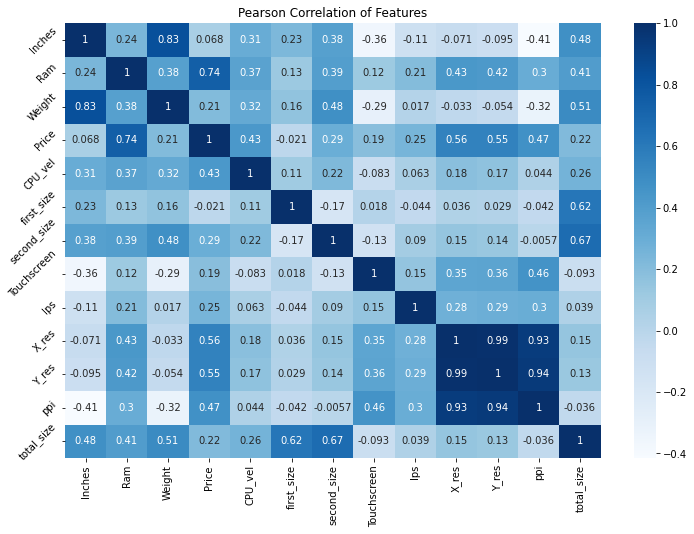

In [22]:
corr = df1.corr()

f, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(corr, cmap="Blues", annot=True, square=False, ax=ax)
plt.title('Pearson Correlation of Features')
plt.yticks(rotation=45);

In [30]:
# get object feat
cat_features = df1.select_dtypes(include=['object']).columns.to_list()

In [35]:
# get numeric feat 
num_features=df1.select_dtypes(include=['int','float']).columns.to_list()

In [31]:
LOO_f=[f_+'_loo' for f_ in cat_features]

In [ ]:
sklearn.model

In [16]:
!pip install -U scikit_learn

In [17]:
sklearn.__version__

'1.1.3'

In [43]:
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

train,test = split_train_test(df1, test_size=0.2,shuffle=True)

In [47]:
df1.columns.drop(target)

Index(['Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram',
       'Memory', 'Gpu', 'OpSys', 'Weight', 'Cpu_brand', 'CPU_vel', 'GPU',
       'first_size', 'first_type', 'second_size', 'second_type', 'Touchscreen',
       'Ips', 'X_res', 'Y_res', 'ppi', 'os', 'total_size'],
      dtype='object')

In [12]:
!pip install  category_encoders

In [13]:
# Leave-One-Out Encoder

import category_encoders as ce
encoder = ce.LeaveOneOutEncoder(return_df=True)

In [14]:
target='Price'
features=df1.columns.drop(target)
X=df1[features]
y=df1[target]
X_train_loo = encoder.fit_transform(X, y)
#X_train_loo.dtypes

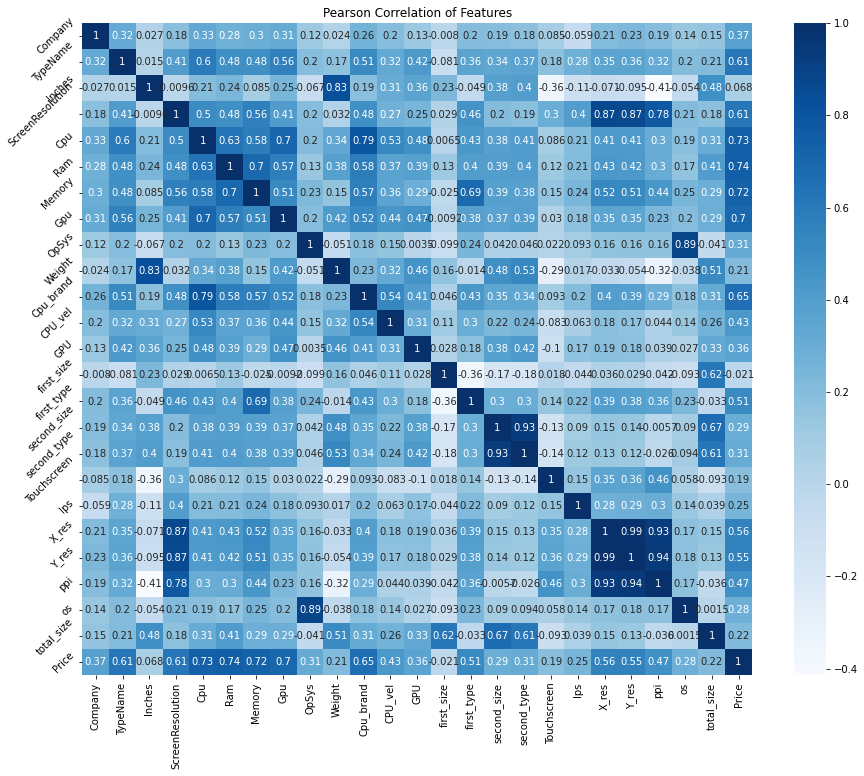

In [18]:
X_train_loo['Price']=y
corr = X_train_loo.corr()

f, ax = plt.subplots(figsize=(15, 12))

sns.heatmap(corr, cmap="Blues", annot=True, square=False, ax=ax)
plt.title('Pearson Correlation of Features')
plt.yticks(rotation=45);

In [23]:
# Leave-One-Out Encoder

import category_encoders as ce
encoder = ce.LeaveOneOutEncoder(return_df=True)

In [20]:
from lazytransform import LazyTransformer
lazy = LazyTransformer(model=None, encoders='auto', scalers=None, 
        date_to_string=False, transform_target=True, imbalanced=False,
        combine_rare=False, verbose=0)

In [40]:
# shuffer dataframe rows
def shuffle(df):
    return df.sample(frac=1)

# split to train and test
def split_train_test(df_, test_size=0.2,shuffle=True):
    if shuffle:
        df_=df_.sample(frac=1)
    return sklearn.model_selection.train_test_split(df_, test_size=test_size)

In [13]:
train,test=split_train_test(df, test_size=0.2,shuffle=True)
X_train=train.iloc[:,:-1]
y_train=train.iloc[:,-1]

In [15]:
X_test=test.iloc[:,:-1]
y_test=test.iloc[:,-1]

In [21]:
X_trainm, y_trainm = lazy.fit_transform(X_train, y_train)
X_testm = lazy.transform(X_test)

    Regression models don't need targets to be transformed to numeric...
#### Single_Label Regression problem ####
Shape of dataset: (1042, 10). Now we classify variables into different types...
Time taken to define data pipeline = 1 second(s)
No model input given...
X and y Transformer Pipeline created...
    Time taken to fit dataset = 1 second(s)
    Time taken to transform dataset = 1 second(s)
    Shape of transformed dataset: (1042, 49)
    Time taken to transform dataset = 1 second(s)
    Shape of transformed dataset: (261, 49)


In [24]:
X_testm.head()

,Company_HP,Company_Dell,Company_Lenovo,Company_Razer,Company_MSI,Company_Asus,Company_Acer,Company_Apple,Company_Fujitsu,Company_Toshiba,...,OpSys_ChromeOS,OpSys_MacOSX,OpSys_Windows10S,OpSys_Android,ScreenResolution_encoded,Cpu_encoded,Memory_encoded,Gpu_encoded,Weight_encoded,Inches
811,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,8,96,30,77,142,17.299999
901,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,15,87,19,90,156,17.299999
291,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,8,96,10,72,161,17.299999
378,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,34,23,41,53,14.000000
568,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,8,107,26,42,109,15.600000


In [25]:
X_test.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
811,MSI,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg
901,Asus,Gaming,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 6820HK 2.7GHz,32GB,256GB SSD + 256GB SSD,Nvidia GeForce GTX 980M,Windows 10,3.58kg
291,Asus,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,1TB HDD,Nvidia GeForce GTX 1050,Windows 10,3kg
378,Asus,Notebook,14.0,1366x768,Intel Celeron Dual Core N3350 1.1GHz,4GB,32GB Flash Storage,Intel HD Graphics 500,Windows 10,1.5kg
568,Lenovo,Notebook,15.6,Full HD 1920x1080,Intel Pentium Quad Core N4200 1.1GHz,4GB,500GB HDD,Intel HD Graphics 505,Windows 10,2.2kg


In [19]:
from pycaret.regression import *


In [20]:
data=X_train_loo

reg1 = setup(data = data, target = 'Price')

,Description,Value
0,Session id,7955
1,Target,Price
2,Target type,Regression
3,Data shape,"(1303, 25)"
4,Train data shape,"(912, 25)"
5,Test data shape,"(391, 25)"
6,Numeric features,24
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


In [21]:
# Compare models, 各種模型的比較
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,499.0658,7196316.0258,1736.1227,0.9792,0.0445,0.0166,0.1130
et,Extra Trees Regressor,658.9669,7408214.6247,1986.7808,0.9769,0.0587,0.0242,0.0760
gbr,Gradient Boosting Regressor,1054.3470,8778816.0111,2259.9621,0.9702,0.0877,0.0514,0.0670
xgboost,Extreme Gradient Boosting,878.9732,10140994.8534,2368.1551,0.9671,0.0701,0.0329,0.0770
catboost,CatBoost Regressor,930.5819,13616550.5019,2462.7102,0.9599,0.0725,0.0386,1.0860
lightgbm,Light Gradient Boosting Machine,1006.2983,12078811.0280,2711.1918,0.9587,0.0713,0.0358,0.1170
dt,Decision Tree Regressor,571.9995,10865788.1032,2340.6187,0.9567,0.0646,0.0191,0.0120
ada,AdaBoost Regressor,2987.4458,19299073.7496,4203.2217,0.9150,0.2768,0.2293,0.0410
llar,Lasso Least Angle Regression,4711.7888,43306795.1405,6487.8554,0.7912,0.3878,0.2427,0.0110
en,Elastic Net,4711.6777,43490554.3388,6499.8454,0.7906,0.3730,0.2426,0.0120


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

RandomForestRegressor(n_jobs=-1, random_state=7955)

In [22]:
cat = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,854.7874,3732462.7041,1931.9583,0.9810,0.0704,0.0394
1,878.6966,6032101.9298,2456.0338,0.9707,0.1144,0.0520
2,833.0577,2938766.7672,1714.2832,0.9832,0.0565,0.0334
3,586.7484,779837.8941,883.0843,0.9961,0.0366,0.0270
4,777.8463,1442879.8609,1201.1993,0.9934,0.0715,0.0454
5,584.5098,904758.3292,951.1879,0.9954,0.0535,0.0346
6,772.1902,3696643.6365,1922.6658,0.9795,0.0500,0.0309
7,2715.9085,111303332.8503,10550.0395,0.7327,0.1493,0.0573
8,769.8724,4556844.1453,2134.6766,0.9723,0.0766,0.0360


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [23]:
pred_cat = predict_model(cat)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,767.4548,6893510.5892,2625.5496,0.9670,0.0595,0.0327


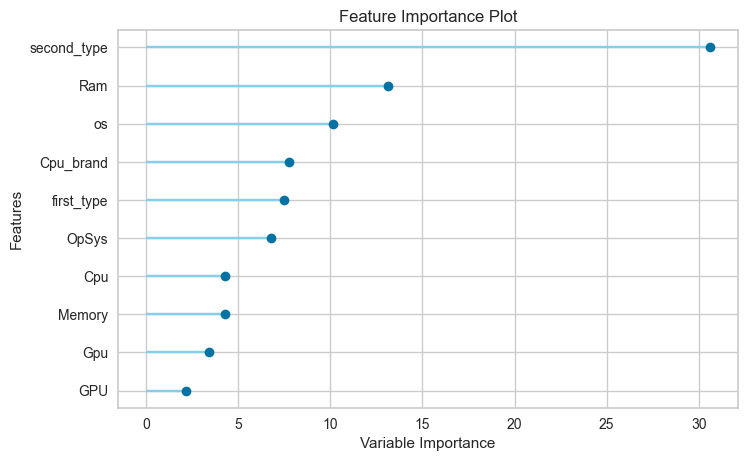

In [24]:
# Plot of Feature Importance
plot_model(cat, plot='feature')

In [25]:
pred_cat[['Price','prediction_label']]

,Price,prediction_label
912,6300,6523.072939
913,22600,21977.921716
914,13700,14893.899560
915,29600,28989.823714
916,16600,16677.692109
...,...,...
1298,18900,18481.165760
1299,10300,11260.067424
1300,20300,20154.308450
1301,18000,17772.935912


Model Tuned
---
1. split data into train/test sets and build model by training set and validated by test set. 
2. repeated 10 folds to get the optimized one

In [26]:
cat_tun=tune_model(cat)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2277.9176,17548135.6325,4189.0495,0.9107,0.1990,0.1437
1,2001.0118,15477676.0514,3934.1678,0.9248,0.2309,0.1554
2,1734.5256,5890771.1288,2427.0911,0.9662,0.1295,0.0906
3,1898.6696,8192322.9398,2862.2234,0.9586,0.1417,0.0997
4,2125.3972,7337236.3297,2708.7333,0.9664,0.1825,0.1409
5,1681.9653,4733347.9002,2175.6259,0.9759,0.2086,0.1471
6,1757.0117,10372800.4167,3220.6832,0.9424,0.1500,0.1023
7,3632.5792,135174375.5577,11626.4515,0.6754,0.1938,0.1054
8,1454.5560,6692488.3606,2586.9844,0.9593,0.1301,0.0858


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [27]:
pred_cat2 = predict_model(cat_tun)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,767.4548,6893510.5892,2625.5496,0.9670,0.0595,0.0327


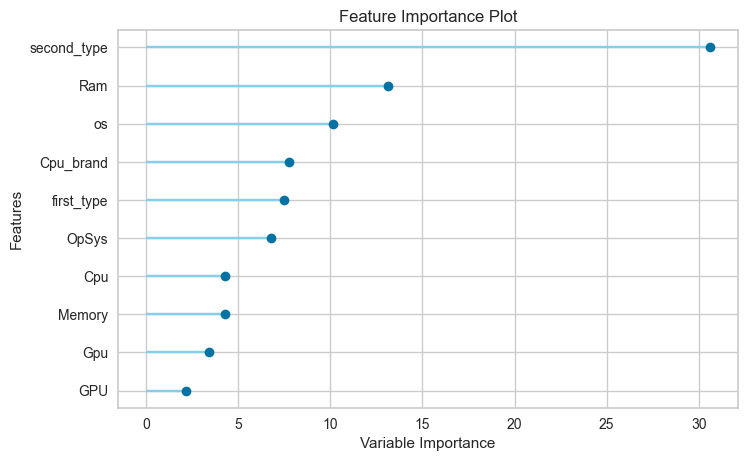

In [28]:
# Plot of Feature Importance
plot_model(cat_tun, plot='feature')

In [29]:
pred_cat2[['Price','prediction_label']]

,Price,prediction_label
912,6300,6523.072939
913,22600,21977.921716
914,13700,14893.899560
915,29600,28989.823714
916,16600,16677.692109
...,...,...
1298,18900,18481.165760
1299,10300,11260.067424
1300,20300,20154.308450
1301,18000,17772.935912


In [70]:
pred_cat2

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,...,second_type,Touchscreen,Ips,X_res,Y_res,ppi,os,total_size,Price,prediction_label
912,22545.607422,16199.862305,15.600000,23996.640625,27821.804688,4.0,13943.946289,12858.333008,24229.318359,2.20,...,21343.693359,0.0,0.0,1920.0,1080.0,141.212006,24678.025391,1000.0,16600,15891.604564
913,22141.392578,16193.250977,14.000000,23987.154297,21662.687500,4.0,12936.641602,21796.738281,35311.363281,1.54,...,21339.304688,0.0,0.0,1920.0,1080.0,157.350510,24673.753906,0.0,21400,21098.139679
914,68950.000000,35744.117188,14.000000,23885.771484,36280.000000,16.0,63092.308594,36948.937500,24176.937500,1.95,...,21292.414062,0.0,0.0,1920.0,1080.0,157.350510,24628.113281,1000.0,72700,65597.390959
915,22526.689453,16192.148438,14.000000,28132.314453,21650.746094,8.0,25502.189453,21792.390625,24224.089844,1.90,...,21338.574219,0.0,1.0,1920.0,1080.0,157.350510,24673.042969,256.0,22200,22372.982128
916,22172.894531,16205.096680,15.600000,24004.150391,19660.562500,6.0,25525.060547,12531.250000,24232.867188,1.91,...,21347.166016,0.0,0.0,1920.0,1080.0,141.212006,24681.406250,256.0,12800,12210.548710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,24460.810547,35787.746094,17.299999,27950.654297,36341.378906,32.0,50992.308594,53893.101562,24185.248047,4.42,...,33258.707031,0.0,1.0,1920.0,1080.0,127.335678,24636.031250,1512.0,63800,65011.375829
1299,22568.917969,16209.366211,15.600000,24010.277344,10255.555664,4.0,13974.887695,11925.000000,24235.761719,2.20,...,21350.000000,0.0,0.0,1920.0,1080.0,141.212006,24684.164062,1000.0,9700,9542.684867
1300,22524.662109,16191.322266,14.000000,28129.693359,19015.873047,8.0,25500.730469,19314.285156,24223.529297,1.50,...,21338.025391,0.0,1.0,1920.0,1080.0,157.350510,24672.509766,256.0,22800,22849.550654
1301,22578.041016,16213.084961,15.600000,11230.713867,10193.333008,4.0,13986.995117,21875.000000,12246.154297,1.90,...,21352.468750,0.0,0.0,1366.0,768.0,100.454666,12272.435547,1000.0,7000,7212.410013


In [32]:
final_cat = finalize_model(cat_tun)
save_model(final_cat, 'deloyment_xxx')

Transformation Pipeline and Model Successfully Saved


(<catboost.core.CatBoostRegressor at 0x7f7cd4814ee0>, 'deloyment_xxx.pkl')

Feature Selection
---
Feature Selection in Machine Learning is selecting the most impactful features; advantages, come from this, include a) reducing time consuming in model building, training; b) simplifying the interpretation of model; c) reducing th conflict among features. But how? the selection rules might be distinct and depend on types of features:
1. Numerical features: Pearson's correlation coefficient, principal component analysis (PCA);
2.Categorical features: $\chi^2$ test;
3. And `Feature Importance` suits for  both types.



In [89]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np

In [72]:
def select_features(X_train, y_train, X_test, k_value='all'):
    fs = SelectKBest(score_func=chi2, k=k_value)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [79]:
df2=df1.copy()
X_train_loo

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,...,second_size,second_type,Touchscreen,Ips,X_res,Y_res,ppi,os,total_size,Price
0,32685.000000,32142.051282,13.3,36260.000000,31500.000000,8,14484.000000,37857.142857,37008.333333,1.37,...,0,21333.455210,0,1,2560,1600,226.983005,32685.000000,128,27800
1,33145.000000,32189.230769,13.3,22500.000000,24000.000000,8,13333.333333,21850.000000,37775.000000,1.34,...,0,21341.864717,0,0,1440,900,127.677940,33145.000000,128,18600
2,22176.190476,16206.336088,15.6,24005.928854,19073.544974,8,25527.250608,23703.928571,12170.769231,1.86,...,0,21347.989031,0,0,1920,1080,141.211998,12241.025641,256,11900
3,31440.000000,32014.358974,15.4,51466.666667,23298.311589,16,38499.145299,23298.311589,34933.333333,1.83,...,0,21310.694698,0,1,2880,1800,220.534624,31440.000000,512,52700
4,32205.000000,32092.820513,13.3,34340.000000,42300.000000,8,25465.206813,42300.000000,36208.333333,1.37,...,0,21324.680073,0,1,2560,1600,226.983005,32205.000000,256,37400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,22557.094595,26709.166667,14.0,25130.769231,26802.083333,4,14678.666667,21841.304348,24232.492997,1.80,...,0,21346.800731,1,1,1920,1080,157.350512,24681.049822,128,13200
1299,22496.621622,26560.000000,13.3,33040.000000,26429.166667,16,38683.760684,21744.021739,24215.779645,1.30,...,0,21330.438757,1,1,3200,1800,276.053530,24665.124555,512,31100
1300,22585.810811,16216.253444,14.0,11238.928571,6870.000000,2,9307.142857,8332.142857,24240.429505,1.50,...,0,21354.570384,0,0,1366,768,111.935204,24688.612100,64,4700
1301,22161.904762,16200.964187,15.6,11199.285714,26747.916667,6,13947.533632,15400.000000,24230.065359,2.19,...,0,21344.424132,0,0,1366,768,100.454670,24678.736655,1000,15800


In [80]:
features= list(X_train_loo.columns)
target = 'Price'
features = [ i for i in features if i!=target]


In [81]:
X=X_train_loo[features]
y=X_train_loo[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [84]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))


Feature 0: 648055.421710
Feature 1: 2156578.970439
Feature 2: 55.372875
Feature 3: 2529914.482469
Feature 4: 3640100.949075
Feature 5: 1902.704221
Feature 6: 3486009.243530
Feature 7: 3379601.325728
Feature 8: 421187.027677
Feature 9: 94.202892
Feature 10: 2746050.491810
Feature 11: 58.870092
Feature 12: 477301.187603
Feature 13: 118944.125879
Feature 14: 1350214.718818
Feature 15: 411386.448505
Feature 16: 362239.146082
Feature 17: 353.433129
Feature 18: 294.443460
Feature 19: 81225.575523
Feature 20: 47466.984841
Feature 21: 7390.315766
Feature 22: 301694.789486
Feature 23: 157626.041661


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, 'Company'),
  Text(1, 0, 'TypeName'),
  Text(2, 0, 'Inches'),
  Text(3, 0, 'ScreenResolution'),
  Text(4, 0, 'Cpu'),
  Text(5, 0, 'Ram'),
  Text(6, 0, 'Memory'),
  Text(7, 0, 'Gpu'),
  Text(8, 0, 'OpSys'),
  Text(9, 0, 'Weight'),
  Text(10, 0, 'Cpu_brand'),
  Text(11, 0, 'CPU_vel'),
  Text(12, 0, 'GPU'),
  Text(13, 0, 'first_size'),
  Text(14, 0, 'first_type'),
  Text(15, 0, 'second_size'),
  Text(16, 0, 'second_type'),
  Text(17, 0, 'Touchscreen'),
  Text(18, 0, 'Ips'),
  Text(19, 0, 'X_res'),
  Text(20, 0, 'Y_res'),
  Text(21, 0, 'ppi'),
  Text(22, 0, 'os'),
  Text(23, 0, 'total_size')])

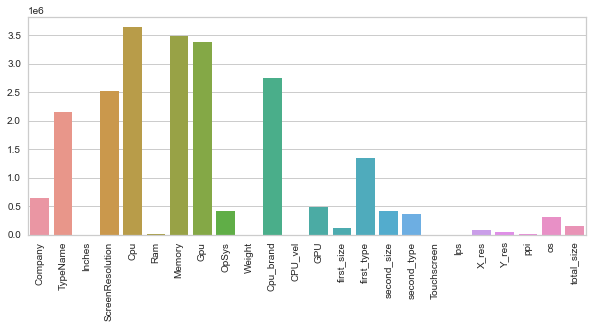

In [92]:
names = []
values = []
for i in range(len(fs.scores_)):
    names.append(features[i])
    values.append(fs.scores_[i])
chi_list = zip(names, values)

# plot the scores
plt.figure(figsize=(10,4))
sns.barplot(x=names, y=values)
plt.xticks(rotation = 90)


In [93]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test,12)
fs.get_feature_names_out()

array(['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu',
       'OpSys', 'Cpu_brand', 'GPU', 'first_type', 'second_size',
       'second_type'], dtype=object)

In [107]:
f_sel=np.append(fs.get_feature_names_out(),target)
data=X_train_loo[f_sel]

reg1 = setup(data = data, target = 'Price')

,Description,Value
0,Session id,8051
1,Target,Price
2,Target type,Regression
3,Data shape,"(1303, 13)"
4,Train data shape,"(912, 13)"
5,Test data shape,"(391, 13)"
6,Numeric features,12
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


In [108]:
compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,418.3751,3385228.1751,1584.3360,0.9849,0.0406,0.0149,0.1140
gbr,Gradient Boosting Regressor,862.5498,4079014.6368,1873.9726,0.9815,0.0677,0.0417,0.0700
dt,Decision Tree Regressor,506.3521,4628589.3454,1981.6383,0.9795,0.0643,0.0187,0.0150
xgboost,Extreme Gradient Boosting,730.1620,5170590.1513,2080.7760,0.9767,0.0567,0.0293,0.0780
catboost,CatBoost Regressor,728.2101,5672709.7388,2048.5722,0.9748,0.0563,0.0315,1.5230
et,Extra Trees Regressor,600.1161,6369686.9472,2316.1305,0.9709,0.0563,0.0206,0.0810
lightgbm,Light Gradient Boosting Machine,937.4894,9746871.9991,2717.4209,0.9571,0.0657,0.0336,0.1700
ada,AdaBoost Regressor,3233.3788,17885267.8782,4183.8300,0.9146,0.3060,0.2592,0.0500
llar,Lasso Least Angle Regression,5353.2838,54755453.5130,7361.8793,0.7377,0.4788,0.2772,0.0130
ridge,Ridge Regression,5369.0572,54918469.4620,7373.4942,0.7368,0.4839,0.2788,0.0130


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

RandomForestRegressor(n_jobs=-1, random_state=8051)

In [109]:
cat2 = create_model('catboost')
cat_tun2=tune_model(cat2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,642.1672,1789269.9837,1337.6360,0.9902,0.0457,0.0284
1,469.2155,518284.9994,719.9201,0.9971,0.0513,0.0307
2,660.5634,4316788.3501,2077.6882,0.9784,0.0472,0.0287
3,1213.5094,19032686.3152,4362.6467,0.9303,0.0876,0.0418
4,1016.0052,5246964.3685,2290.6253,0.9830,0.0649,0.0371
5,795.9073,15343821.6372,3917.1190,0.9222,0.0657,0.0326
6,778.4318,7252390.1864,2693.0262,0.9644,0.0656,0.0331
7,526.6833,716843.3141,846.6660,0.9961,0.0405,0.0255
8,606.1512,1224796.9218,1106.7054,0.9935,0.0402,0.0274


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1470.5007,7180566.6180,2679.6579,0.9605,0.0911,0.0637
1,913.0753,1520784.3413,1233.2009,0.9914,0.0781,0.0551
2,1027.7985,2676146.3190,1635.8931,0.9866,0.0757,0.0545
3,1575.8133,15605355.7624,3950.3615,0.9429,0.1206,0.0656
4,1608.6948,11978116.2820,3460.9415,0.9612,0.0890,0.0569
5,1023.2073,12755607.4166,3571.4993,0.9353,0.0812,0.0486
6,860.4868,2357024.3645,1535.2604,0.9884,0.0716,0.0418
7,922.5443,2102274.7644,1449.9223,0.9885,0.0616,0.0416
8,1020.6900,3251996.1494,1803.3292,0.9828,0.0551,0.0409


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


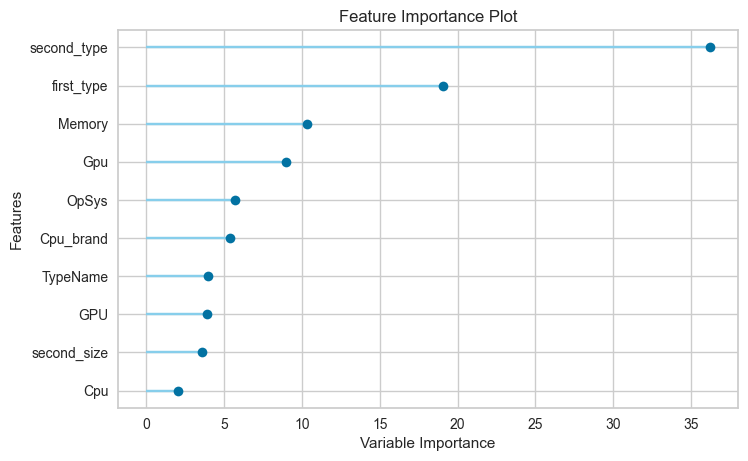

In [110]:
# Plot of Feature Importance
plot_model(cat_tun2, plot='feature')

In [111]:
pred_cat2 = predict_model(cat_tun2)
pred_cat2[['Price','prediction_label']]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,590.1798,2883210.4406,1698.0019,0.9859,0.0716,0.0321


,Price,prediction_label
912,11700,11593.038215
913,5700,6048.836675
914,30700,31177.424773
915,19500,19592.402732
916,10300,10322.528260
...,...,...
1298,4100,8111.777998
1299,13800,13977.385356
1300,15500,15747.402825
1301,10100,9972.025555


Practicing
---
Here, both  techniques of EDA, feature encoder and feature selection, are introduced. However, original features did not deleted after encoded; this should conflict with purpose of encoding: making data clear. Try to delete the un-necessary features (before encoder) and create model again.     